In [1]:
!pip install xgboost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
#store = pd.HDFStore('X_pca.h5')
#X_pca = store['X_pca']

store = pd.HDFStore('X_pca.h5')
X_pca = store['X_pca']

store = pd.HDFStore('X_mob.h5')
X_mob = store['X_mob']

store = pd.HDFStore('y_default.h5')
y_default = store['y_default']

store = pd.HDFStore('y_prepay.h5')
y_prepay = store['y_prepay']

X_pca = X_pca.join(X_mob)

In [3]:
X_pca_add = X_pca[X_pca['mob']>2].copy()
X_pca_add['mob'] = np.floor(X_pca_add['mob']/2)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [4]:
X_pca_add = X_pca[X_pca['mob']>4].copy()
X_pca_add['mob'] = np.ceil(X_pca_add['mob']/4*3)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [5]:
X_pca_add = X_pca[X_pca['mob']>4].copy()
X_pca_add['mob'] = np.floor(X_pca_add['mob']/4)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [10]:
X_pca

,0,1,2,3,4,5,6,7,8,9,10,mob,Orig_month,Orig_year
0,0.717521,-0.458524,1.433562,1.046494,0.164595,-0.072055,-0.030477,-0.168625,-0.026212,0.399204,-0.980749,45.0,4,2016
1,2.244616,-1.030425,-2.443468,-0.576140,0.748542,-0.115527,1.318192,0.025524,0.144284,-0.892829,0.537241,36.0,5,2016
2,0.310954,0.027425,-1.540056,0.840923,-0.836991,-0.101286,0.769092,0.116545,0.204194,-0.554330,0.878635,36.0,4,2016
3,0.383023,-1.832473,-0.242715,0.706981,-0.896038,0.766941,0.857497,0.164902,0.243484,-0.455246,1.471685,37.0,5,2016
4,2.691928,1.549250,1.128812,1.238563,-0.146378,0.364322,1.418887,-0.103755,0.294065,-0.282789,-1.066466,36.0,6,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486687,3.102019,-0.303563,0.239899,-0.205121,-1.183502,0.898389,0.177814,0.336460,0.093494,0.009883,0.932587,2.0,11,2018
446140,0.477387,2.426233,-1.820486,-1.914835,1.096685,-1.209694,0.028853,-0.005311,-0.134923,-0.613278,0.002510,5.0,2,2018
85109,-0.360165,-0.148433,-0.300854,0.403110,0.519812,-1.002563,-1.088226,-0.185485,-0.264521,0.664559,-1.002789,5.0,7,2018
591899,1.116386,-1.588043,-0.719157,-3.778188,0.077680,-0.541598,-0.125197,0.201429,-0.065842,-0.726900,1.484273,2.0,11,2017


In [6]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_default, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[23:45:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
No Skill: ROC AUC=0.500
XGBClassifier: ROC AUC=0.809


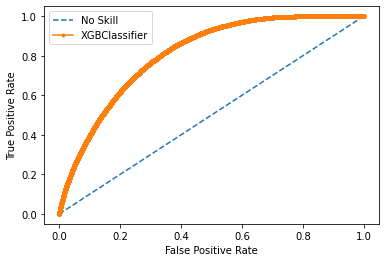

165.203604221344 s


In [7]:
time_start = time.time()
model = xgb.XGBClassifier(max_depth= 3, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

# save the model to disk
filename = 'xgb_model_no_Time_default.sav'
#filename = 'xgb_model_date_default.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))


# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")

In [8]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_prepay, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[23:47:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
No Skill: ROC AUC=0.500
XGBClassifier: ROC AUC=0.696


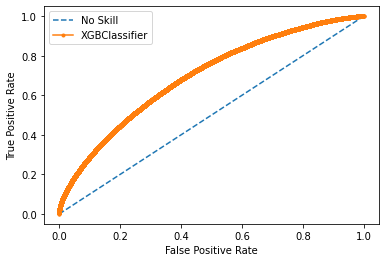

160.206116437912 s


In [9]:
time_start = time.time()
model = xgb.XGBClassifier(max_depth= 3, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

filename = 'xgb_model_no_Time_prepay.sav'
#filename = 'xgb_model_date_prepay.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")